# Statistik-Projekt HS25 – Data Engineering
## Notebook 1: Bereinigung und Vorbereitung der IST-Daten

Dieses Notebook bildet das Fundament. Wir transformieren die Rohdaten (65 Mio. Zeilen) in einen analysefähigen Datensatz.
**Technik:** Wir nutzen `Polars` statt Pandas für Performance.

### 1. Setup & Bibliotheken
Wir laden `Polars` für schnelles Data-Processing und setzen das Plotting-Theme.

In [1]:

import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Plotting Style
sns.set_context("talk")
sns.set_style("whitegrid")

print("Setup abgeschlossen. Polars Version:", pl.__version__)

Setup abgeschlossen. Polars Version: 1.35.2


### 2. Daten laden & Filtern
Wir laden das `parquet`-File (effizienter als CSV) und filtern sofort auf **Züge** (`PRODUKT_ID == "Zug"`), da Busse und Trams die Verspätungsstatistik verzerren würden. Ausserdem können wir so Kernel-Crashes vermeiden, da wir mit weniger Daten arbeiten.

In [2]:
# Pfad zu den Daten
data_path = Path("../data/processed/istdata_real_2025-09.parquet")

# Laden mit Polars
raw_df = pl.read_parquet(data_path)

print(f"Rohdaten geladen: {raw_df.height:,} Zeilen.")

# Filterung auf Züge
# Polars Syntax: .filter(pl.col('Spalte') == 'Wert')
df = raw_df.filter(pl.col('PRODUKT_ID') == 'Zug')

print(f"Daten nach Filterung auf 'Zug': {df.height:,} Zeilen.")
with pl.Config(tbl_cols=-1, tbl_width_chars=1000):
    print(df.head())

Rohdaten geladen: 65,941,060 Zeilen.
Daten nach Filterung auf 'Zug': 4,615,140 Zeilen.
shape: (5, 12)
┌─────────────┬─────────────────────────────────┬────────────┬─────────────┬───────────────────┬─────────────────────────┬─────────────────────────┬─────────────────┬───────────────────┬─────────┬───────────────┬─────────┐
│ BETRIEBSTAG ┆ BETREIBER_NAME                  ┆ PRODUKT_ID ┆ LINIEN_TEXT ┆ HALTESTELLEN_NAME ┆ ANKUNFTSZEIT            ┆ ABFAHRTSZEIT            ┆ delay_arrival_s ┆ delay_departure_s ┆ on_time ┆ FAELLT_AUS_TF ┆ BPUIC   │
│ ---         ┆ ---                             ┆ ---        ┆ ---         ┆ ---               ┆ ---                     ┆ ---                     ┆ ---             ┆ ---               ┆ ---     ┆ ---           ┆ ---     │
│ str         ┆ str                             ┆ cat        ┆ str         ┆ str               ┆ datetime[ns, UTC]       ┆ datetime[ns, UTC]       ┆ f64             ┆ f64               ┆ bool    ┆ bool          ┆ str     │
╞═════

## 2. Analyse fehlender Werte (Missing Values)
Untersuchung der Datenlücken bei Verspätungen.

Anteil fehlender Werte in % (Nur Züge):
ANKUNFTSZEIT: 8.78%
ABFAHRTSZEIT: 8.42%
delay_arrival_s: 8.95%
delay_departure_s: 8.62%


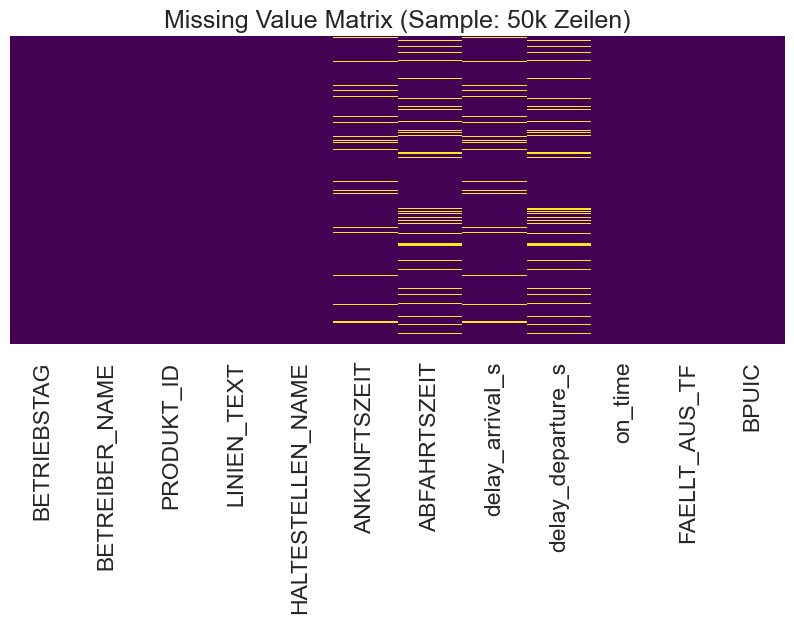

In [3]:

# Prozentualer Anteil fehlender Werte berechnen
total_rows = df.height
null_counts = df.null_count()

print("Anteil fehlender Werte in % (Nur Züge):")
for col in df.columns:
    n_null = null_counts[col][0]
    if n_null > 0:
        print(f"{col}: {n_null / total_rows * 100:.2f}%")

# Visualisierung (Sampling für Performance, Konvertierung zu Pandas nur für den Plot)
sample_pdf = df.sample(n=50000, seed=42).to_pandas()

plt.figure(figsize=(10, 4))
sns.heatmap(sample_pdf.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Value Matrix (Sample: 50k Zeilen)")
plt.show()

## 3. Strategie für Missing Values
 
**Logik:**
* `FAELLT_AUS_TF == True` -> Zug ist ausgefallen -> Zeit *muss* fehlen (Keine Imputation).
* `FAELLT_AUS_TF == False` -> Zug fuhr -> Fehlende Zeit ist ein Datenfehler (Imputation notwendig).

In [4]:

cols_delay = ['delay_arrival_s', 'delay_departure_s']

for col in cols_delay:
    # Fall 1: Strukturell fehlend (Ausfall)
    # Filter: Ausgefallen UND Wert ist null
    n_cancelled_missing = df.filter(
        (pl.col('FAELLT_AUS_TF') == True) & 
        (pl.col(col).is_null())
    ).height
    
    # Fall 2: Technisch fehlend (Zug fuhr, aber Daten fehlen)
    n_running_missing = df.filter(
        (pl.col('FAELLT_AUS_TF') == False) & 
        (pl.col(col).is_null())
    ).height
    
    print(f"Analyse für {col}:")
    print(f"  - Strukturell fehlend (Ausfall): {n_cancelled_missing} (werden NICHT imputiert)")
    print(f"  - Technisch fehlend (Datenfehler): {n_running_missing} (werden imputiert)")
    print("-" * 30)

Analyse für delay_arrival_s:
  - Strukturell fehlend (Ausfall): 0 (werden NICHT imputiert)
  - Technisch fehlend (Datenfehler): 413228 (werden imputiert)
------------------------------
Analyse für delay_departure_s:
  - Strukturell fehlend (Ausfall): 0 (werden NICHT imputiert)
  - Technisch fehlend (Datenfehler): 398030 (werden imputiert)
------------------------------


## 4. Durchführung der Imputation

Wir imputieren fehlende Werte mit dem **Median der jeweiligen Linie** (`LINIEN_TEXT`), aber **nur**, wenn der Zug nicht ausgefallen ist.
Polars Window-Functions (`.over()`) machen das sehr effizient.

In [5]:

# Wir berechnen globale Mediane für den Fallback (falls eine Linie nur NaNs hat)
# Wichtig: Median nur von den Zügen berechnen, die NICHT ausgefallen sind!
global_median_arr = df.filter(pl.col('FAELLT_AUS_TF') == False)['delay_arrival_s'].median()
global_median_dep = df.filter(pl.col('FAELLT_AUS_TF') == False)['delay_departure_s'].median()

# Definition der Imputations-Expression
def impute_delay(col_name, global_med):
    # 1. Berechne Median pro Linie (Window Function)
    line_median = pl.col(col_name).median().over("LINIEN_TEXT")
    
    # 2. Wähle Wert: Original -> Linien-Median -> Globaler Median
    # coalese nimmt den ersten nicht-null Wert
    filled_value = pl.coalesce([pl.col(col_name), line_median, pl.lit(global_med)])
    
    # 3. Wende Logik an: Wenn Ausgefallen (True) -> behalte Original (Null), sonst -> nimm filled_value
    return (
        pl.when(pl.col("FAELLT_AUS_TF")) # Wenn True (Ausgefallen)
        .then(pl.col(col_name))          # Behalte Original (NaN)
        .otherwise(filled_value)         # Sonst imputieren
    )

# Anwenden der Transformation
df = df.with_columns([
    impute_delay("delay_arrival_s", global_median_arr).alias("delay_arrival_s"),
    impute_delay("delay_departure_s", global_median_dep).alias("delay_departure_s")
])

print("Imputation mit Polars abgeschlossen.")

Imputation mit Polars abgeschlossen.


## 5. Validierung der Bereinigung
 
Prüfen, ob fahrende Züge nun vollständig sind und ausgefallene Züge weiterhin NaNs haben.

In [6]:

# Check 1: Fahrende Züge mit NaNs? (Sollte 0 sein)
check_running_nan = df.filter(
    (pl.col('FAELLT_AUS_TF') == False) & 
    (pl.col('delay_arrival_s').is_null() | pl.col('delay_departure_s').is_null())
).height

# Check 2: Ausgefallene Züge mit NaNs? (Sollte > 0 sein)
check_cancelled_nan = df.filter(
    (pl.col('FAELLT_AUS_TF') == True) & 
    (pl.col('delay_arrival_s').is_null())
).height

print(f"Verbleibende NaNs bei fahrenden Zügen (Soll: 0): {check_running_nan}")
print(f"Verbleibende NaNs bei ausgefallenen Zügen (Soll: >0): {check_cancelled_nan}")

if check_running_nan == 0:
    print("ERFOLG: Datenlücken bei fahrenden Zügen geschlossen.")
else:
    print(f"WARNUNG: {check_running_nan} Fälle nicht imputiert.")

Verbleibende NaNs bei fahrenden Zügen (Soll: 0): 0
Verbleibende NaNs bei ausgefallenen Zügen (Soll: >0): 0
ERFOLG: Datenlücken bei fahrenden Zügen geschlossen.


## 6. Analyse fehlender Werte (Missing Values)
Untersuchung der Datenlücken bei Verspätungen.

Anteil fehlender Werte in % (Nur Züge):
ANKUNFTSZEIT: 8.78%
ABFAHRTSZEIT: 8.42%


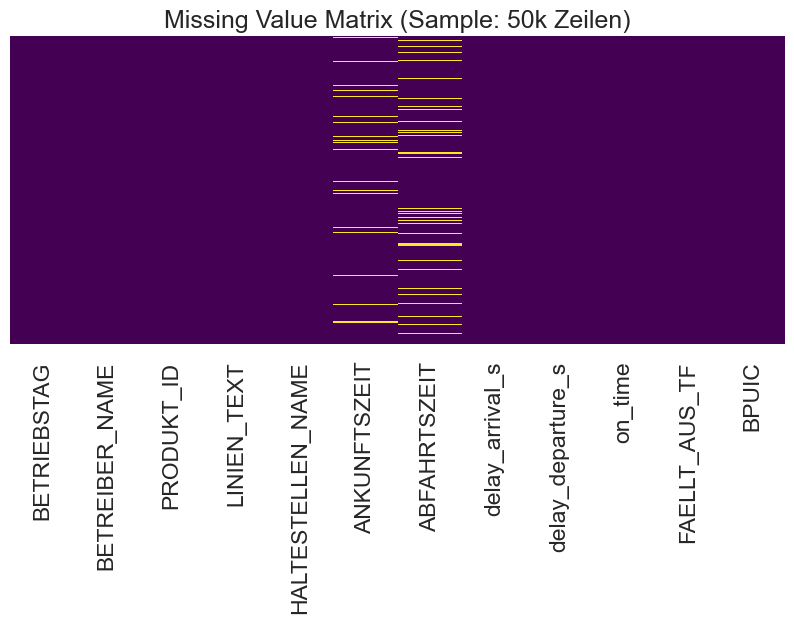

In [7]:

# Prozentualer Anteil fehlender Werte berechnen
total_rows = df.height
null_counts = df.null_count()

print("Anteil fehlender Werte in % (Nur Züge):")
for col in df.columns:
    n_null = null_counts[col][0]
    if n_null > 0:
        print(f"{col}: {n_null / total_rows * 100:.2f}%")

# Visualisierung (Sampling für Performance, Konvertierung zu Pandas nur für den Plot)
sample_pdf = df.sample(n=50000, seed=42).to_pandas()

plt.figure(figsize=(10, 4))
sns.heatmap(sample_pdf.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Value Matrix (Sample: 50k Zeilen)")
plt.show()

## 7. Feature Engineering
Extrahieren von Zeitinformationen.
Polars speichert Strings oft nicht automatisch als Datum, wir konvertieren explizit.

In [8]:

# Datum parsen (Format anpassen: dd.mm.yyyy)
# Hinweis: Wenn das Datum bereits korrekt geladen wurde (als Date), ist str.to_date nicht nötig.
# Wir prüfen den Datentyp.
if df['BETRIEBSTAG'].dtype == pl.Utf8:
    df = df.with_columns(
        pl.col('BETRIEBSTAG').str.to_date("%d.%m.%Y")
    )

# Wochentage und Wochenende extrahieren
# Polars: Monday = 1, Sunday = 7
df = df.with_columns([
    # Wochentag als String (für Plots)
    pl.col('BETRIEBSTAG').dt.strftime("%A").alias("Wochentag_Name"),
    
    # Ist Wochenende? (Samstag=6, Sonntag=7)
    (pl.col('BETRIEBSTAG').dt.weekday() >= 6).alias("Ist_Wochenende")
])

# Verteilung prüfen
print("Verteilung der Zugfahrten nach Wochentag:")
print(df['Wochentag_Name'].value_counts())

Verteilung der Zugfahrten nach Wochentag:
shape: (7, 2)
┌────────────────┬────────┐
│ Wochentag_Name ┆ count  │
│ ---            ┆ ---    │
│ str            ┆ u32    │
╞════════════════╪════════╡
│ Tuesday        ┆ 782906 │
│ Wednesday      ┆ 628584 │
│ Saturday       ┆ 599528 │
│ Monday         ┆ 781260 │
│ Sunday         ┆ 559219 │
│ Friday         ┆ 634738 │
│ Thursday       ┆ 628905 │
└────────────────┴────────┘


Top 10 Zug-Betreiber:
shape: (10, 2)
┌─────────────────────────────────┬─────────┐
│ BETREIBER_NAME                  ┆ len     │
│ ---                             ┆ ---     │
│ str                             ┆ u32     │
╞═════════════════════════════════╪═════════╡
│ Schweizerische Bundesbahnen SB… ┆ 1901628 │
│ BLS AG (bls)                    ┆ 461639  │
│ THURBO                          ┆ 395503  │
│ Aargau Verkehr AG               ┆ 194534  │
│ Schweizerische Südostbahn (sob… ┆ 181387  │
│ Rhätische Bahn                  ┆ 155821  │
│ Regionalverkehr Bern-Solothurn  ┆ 146497  │
│ Appenzeller Bahnen (ab)         ┆ 145425  │
│ Zentralbahn                     ┆ 96056   │
│ Transports Publics du Chablais  ┆ 94110   │
└─────────────────────────────────┴─────────┘


/var/folders/31/yls2dr0n48xgy85yyf73qr9w0000gn/T/ipykernel_33488/803913714.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


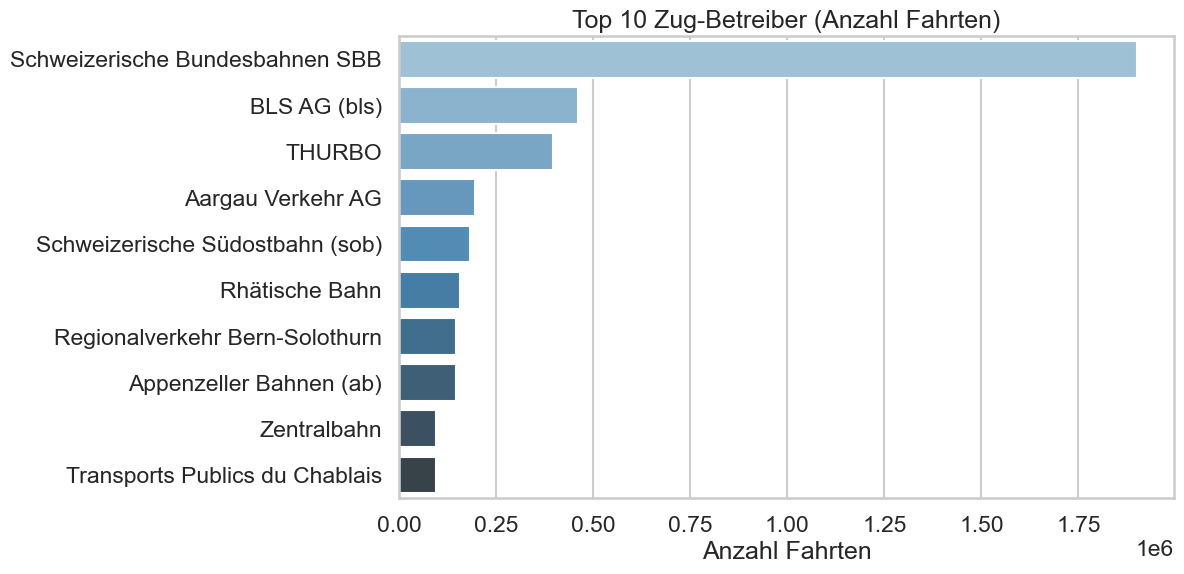

In [9]:
# Aggregieren: Wer fährt die Züge?
top_operators = (
    df.group_by("BETREIBER_NAME")
    .len()
    .sort("len", descending=True)
    .head(10)
)

print("Top 10 Zug-Betreiber:")
print(top_operators)

# Visualisierung
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_operators.to_pandas(), 
    x="len", 
    y="BETREIBER_NAME", 
    palette="Blues_d"
)
plt.title("Top 10 Zug-Betreiber (Anzahl Fahrten)")
plt.xlabel("Anzahl Fahrten")
plt.ylabel("")
plt.show()

## 8. Export
Speichern des bereinigten Datensatzes.

In [10]:

output_path = Path("../data/processed/istdata_trains_clean.parquet")
df.write_parquet(output_path)

print(f"Bereinigter Datensatz gespeichert unter: {output_path}")
print(f"Finale Dimensionen: {df.height} Zeilen, {df.width} Spalten")

Bereinigter Datensatz gespeichert unter: ../data/processed/istdata_trains_clean.parquet
Finale Dimensionen: 4615140 Zeilen, 14 Spalten
